## Why Low Accuracy with Logistics Regression

Logistics Regression use following equations

$$z=w_1x_1+w_2x_2+w_3x_3+...+w_nx_n+b$$

$$y=\sigma(z)=\frac 1{1+e^{-z}}$$

So basically, it is just put a weight on each pixel, and adding a bias afterwards. 

It's an extreme simple algorithm with just one neural. It's a linear algorithm. While the world is not linear, so it can just catch part of the features. It is not bad to achieve 70% accuracy. 

## From Logistic Regression to 2 Layers Neural Network

By adding one more layer in the algorithm, the accuracy will be improved quite bit. 

![Logistic-Regression-2Layers-NN](../images/Logistic-Regression-2Layers-NN.png)

## Forward Propagation Equations

Here are **forward propagation** equations for the 2 layers neural network. It use tanh activation function in this case.

$$\begin{align*} 
Z^1 &= W^1\cdot X + b^1 \\
[n_1, m] &\Leftarrow [n_1, n_x] \cdot  [n_x, m] + [n_1, 1]\\
A^1 &= tanh (Z^1)\\
Z^2 &= W^2\cdot Z^1 + b^2 \\
[n_y, m] &\Leftarrow [n_y, n_1] \cdot  [n_1, m] + [n_y, 1]\\
A^1 &= \sigma (Z^2)
\end{align*} $$

With these equation, it can be transformed to the following Python code

```python
import numpy as np
Z1 = np.dot(W1, X) + b1
A1 = np.tanh(Z1)
Z2 = np.dot(W2, A1) + b2
A2 = 1.0 / (1.0 + np.exp(-Z2))
```    

## Forward Propagation Dimensions

In the cat/none-cat classification problem, 

- \\(n_x=64*64*3\\), the input dimension, 
- \\(n_y = 1\\), the out dimension, only one value
- \\(n_1=10\\), if just pick the hidden layer size. This number will be adjusted later in the blog to test different accuracy result.


For all the variables used in the forward propagation have shape

|parameter|shape|shape value|
|:--------|:----|:----------|
| X       | [n_x, m]  | [12288, m]|
| A1/Z1   | [n_1, m]  | [10, m]
| Y/A2/Z2 | [n_y, m]  | [1, m]|
| W1      | [n_1, n_x]| [10,12288]|
| b1      | [n_1, 1]  | [10, 1] |
| W2      | [n_y, n_1]| [1,10]|
| b2      | [n_y, 1]  | [1, 1]|

Counting with the number of total parameters. Since the number of input feature(12288) is large. So the weight of the first layer has the largest parameters.

$$\begin{align*} 
n_1*n_x\ +\ n_1 * 1\ +\ n_y * n_1\ +\ n_y * 1 
&= n_1*n_x\ +\ n_1 * 1\ +\ 1 * n_1\ +\ 1 * 1 \\
&= n_1*n_x + 2n_1 + 1 \\
&\approx n_1*n_x
\end{align*} $$

## Propagation Implementation

With all the equations, propagations for 2 layers neural network can be implemented like this

In [6]:
import numpy as np
def propagate(W1, b1, W2, b2, X, Y):
    """
    X: [n_x, m]      train data set
    Y: [n_y,  m]     label data
    W1:[n_1, n_x]    weight for the first layer
    b1:[n_1, 1]      bias for the first layer
    W2:[n_y, n_1]    weight for the second layer
    b1:[n_y, 1]      bias for the first layer
    returns:         dW1, db1, dW2, db2, A2
    """
    Z1 = np.dot(W1, X) + b1                     # [n_1, m]   <= [n_1, n_x] . [n_x, m]
    A1 = np.tanh(Z1)                            # [n_1, m]  
    Z2 = np.dot(W2, A1) + b2                    # [n_y, m]   <= [n_y, n_1] . [n_1, m]
    A2 = 1.0 / (1.0 + np.exp(-Z2))              # [n_y, m]  
    
    dZ2 = A2 - Y                                # [n_y, m] 
    dW2 = np.dot(dZ2, A1.T)                     # [n_y, n_1] <= [n_y, m] .   [n_1, m].T
    db2 = np.sum(dZ2, axis=1, keepdims=True)    # [n_y, 1]   <= [n_y, m]
    
    dgZ1 = 1 - np.power(A1, 2)                  # [n_1, m]
    dZ1  = np.multiply(np.dot(W2.T, dZ2), dgZ1) # [n_1, m]   <= [n_y, n_1].T . [n_y, m]
    dW1  = np.dot(dZ1, X.T)                     # [n_1, n_x] <= [n_1, m]     . [n_x, m].T
    db1  = np.sum(dZ1, axis=1, keepdims=True)   # [n1, 1]    <= [n_1, m]
    
    return dW1, db1, dW2, db2, A2

And the whole training model can be implemented like this

In [10]:
def nn_2_layers(X, Y, n_1, num_iterations=10, learning_rate=0.01, early_stop_cost=0.):
    """
    X: [n_x, m]      train data set
    Y: [n_y, m]      n_y=1 in this case
    n_1:             first hidden layer dimension
    num_iterations:  number iterations
    learning_rate:   learning rate, alpha
    early_stop_cost: early stop cost, if the cost small than this number, the train will stop
    returns:         W1, b1, W2, b2, A, i (A, is the output, i is the number of iterations)
    """
    n_x, m = X.shape
    n_y = 1
    
    W1 = np.random.randn(n_1, n_x) * 0.01
    b1 = np.zeros([n_1, 1])
    W2 = np.random.randn(n_y, n_1) * 0.01
    b2 = np.zeros([n_y, 1])
    print("init weights", W1[0][0], W2[0][0])
        
    costs = []
    
    for i in range(num_iterations):
        dW1, db1, dW2, db2, A = propagate(W1, b1, W2, b2, X, Y)
        print(i, " derivitive", dW1[0][0], dW2[0][0], db1[0][0], db2[0][0])
        
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        print(i, " weights", W1[0][0], W2[0][0])
        
        
        cost = -(np.dot(Y, np.log(A.T)) + np.dot(1-Y, np.log(1-A.T))) / m
        cost = np.squeeze(cost)
        costs.append(cost)
        
        if cost < early_stop_cost:
            break
            
        if i % 100 == 0:
            print(i, cost)

    print(i, cost)
    
    return W1, b1, W2, b2, A, i

## Load the Same Data as Previous blog

In [11]:
import numpy as np
import h5py
    
    
train_dataset = h5py.File('../datasets/train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('../datasets/test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

In [12]:
m_train = train_set_x_orig.shape[0]                           # number of train samples
m_test = test_set_x_orig.shape[0]                             # number of test samples
num_px = train_set_x_orig.shape[1]                            # number pixel on x and y dimension

train_set_x = train_set_x_orig.reshape(m_train, -1).T / 255   # normalize pixel value to [0, 1]
test_set_x = test_set_x_orig.reshape(m_test, -1).T / 255

print(train_set_x.shape, test_set_x.shape)

(12288, 209) (12288, 50)


## Train with 2 layer neural network

In [13]:
import time
start = time.time()
np.random.seed(1)     # set seed, so that the result is comparable 
W1, b1, W2, b2, A, i = nn_2_layers(train_set_x, train_set_y, n_1=100, 
                                num_iterations = 2001, learning_rate = 0.0003, early_stop_cost=0.1)

print("total training time", time.time() - start)

0 0.6797230645612498
100 0.5684633146305869
200 0.3811572089304477
300 0.28990790308726083
400 0.3779718258473503
500 0.12553875998165756
530 0.09870131411447255
total training time 277.2903702259064


## Accuracy for Train and Test Data Set

Accuracy for train set is used to measure how good the model is, for the data it has seen.

Accuracy for train set is used to measure how good the model is, for the data it has **NOT** seen. 
In other words, it is used to measure how general the model is.

With the model we get, we can write followning code to get the accuracy

In [15]:
def accuracy(W1, b1, W2, b2, A):
    train_predict = np.where(A >= 0.5, 1, 0)
    train_accuracy = np.sum(train_predict == train_set_y) / train_set_y.shape[1]
    print("train accuracy", train_accuracy)


    X = test_set_x
    Z1 = np.dot(W1, X) + b1                     # [n_1, n_x] . [n_x, m]     => [n_1, m]        
    A1 = np.tanh(Z1)                            #                              [n_1, m]  
    Z2 = np.dot(W2, A1) + b2                    # [n_y, n_1] . [n_1, m]     => [n_y, m]
    A2 = 1.0 / (1.0 + np.exp(-Z2))              #                              [n_y, m]
    
    test_predict = np.where(A2 >= 0.5, 1, 0)    
    test_accuracy = np.sum(test_predict == test_set_y) / test_set_y.shape[1]
    print("test accuracy", test_accuracy)

    return train_predict, train_accuracy, test_predict, test_accuracy

In [16]:
train_predict, train_accuracy, test_predict, test_accuracy = accuracy(W1, b1, W2, b2, A)

train accuracy 0.980861244019
test accuracy 0.8


## Results with Different Hyper Parameters

Choose different hyper parameters will get different result. 

Here are some results from variance configurations. The best test accuracy got is 80%, better then 70% with logistics regression. From the test, we also see that the accuracy is not always higher when use more neurals.

|n_1|learning rate | stop cost | # iterations| training time | train set accuracy | test accuracy |
|:----|:----|:----------|
| 100 |0.0003 | 0.1  | 2000  |  8 |1 | 0.78 |
| 100 |0.0003 | 0.002  | 2000  |  34 |1 | 0.76 |
| 500 |0.0003 | 0.1      | 471  |  60 |0.9856 | 0.78 |
| 500 |0.0003 | 0.00187  | 2000  |  260 |1 | 0.76 |
| 1000 |0.0003 | 0.1  | 480  |  128 |0.98 | 0.8 |
| 1000 |0.0003 | 0.0017  | 2000  |  530 |1 | 0.74 |
| 2000 |0.0003 | 0.1  | 2000  |  530 |1 | 0.74 |

## Show Wrong Classficiations

wrong predict on train sample  68  to  [0] which should be [1]


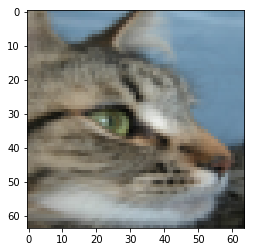

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
wrong_index = np.argmax(train_predict != train_set_y)
print("wrong predict on train sample ", wrong_index, " to ", train_predict[:, wrong_index], 
      "which should be", train_set_y[:, wrong_index])
plt.imshow(train_set_x_orig[wrong_index])


wrong predict on test sample  6  to  [0] which should be [1]


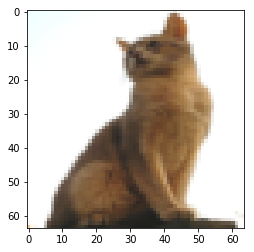

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
wrong_index = np.argmax(test_predict != test_set_y)
print("wrong predict on test sample ", wrong_index, " to ", test_predict[:, wrong_index], 
      "which should be", test_set_y[:, wrong_index])
plt.imshow(test_set_x_orig[wrong_index])



## Goes to More Layers

In the code written before, it is fixed to 2 layers. 

With a little bit extension, it will be able to extend to multiple layers.

In [67]:
import numpy as np
def propagate_n_layer(W, b, X, Y, iter_i):
    """
    X: [n_x, m]
    Y: [n_y  m]
    A1:[n_1, m]
    A2:[n_y, m]
    W1:[n_1, n_x]
    b1:[n_1, 1]
    W2:[n_y, n_1]
    b1:[n_y, 1]
    """
    
    L = len(W) - 1
    
    dA = [l for l in range(L + 1)] # index 0 not used
    dZ = [l for l in range(L + 1)]
    dW = [l for l in range(L + 1)]
    db = [l for l in range(L + 1)]
    Z  = [l for l in range(L + 1)]
    A  = [l for l in range(L + 1)]
    
    A[0] = X

    # Forward propagation, exclude the last layer
    # Using tanh as the activation function
    for l in range(1, L):
        Z[l] = np.dot(W[l], A[l - 1]) + b[l] # (n[l], m) <= (n[l], n[l-1]) . (n[l-1], m) + (n[l], 1)
        A[l] = np.tanh(Z[l])
    
        if iter_i == 0 and 'debug' in globals() and debug:
            shape_info = "Z[l] = np.dot(W[l], A[l - 1]) + b[l] {shape1} <= {shape2} . {shape3} + {shape4}".format(
                shape1=Z[l].shape, shape2=W[l].shape, shape3=A[l-1].shape, shape4=b[l].shape)
            print(l, shape_info)

    # Forward propagation for the last layer
    # Using sigmoid as the activation function
    Z[L] = np.dot(W[L], A[L - 1]) + b[L]
    A[L] = 1.0 / (1.0 + np.exp(-Z[L]))       # sigmoid
    
    # Backward propagation for the last layer
    dA[L] = -(np.divide(Y, A[L]) - np.divide(1 - Y, 1 - A[L]))
    # The way to calculate dZL is different than other layers, due to different activation function
    dZ[L] = A[L] - Y
    dW[L] = np.dot(dZ[L], A[L-1].T)
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)

    # Backward propagation for other layers
    for l in reversed(range(1, L)):
        if iter_i == 0 and 'debug' in globals() and debug:
            print(l, "W[l].shape", W[l].shape, "dZ[l+1].shape", dZ[l+1])

        dgZl = 1 - np.power(A[l], 2)
    
        dZ[l] = np.multiply(np.dot(W[l+1].T, dZ[l+1]), dgZl)

        dW[l] = np.dot(dZ[l], A[l-1].T)
        db[l] = np.sum(dZ[l], axis=1, keepdims=True)
        
    return dW, db, A[L]

In [68]:
def neural_network(X, Y, hidden_layer_dims, num_iterations=10, learning_rate=0.01, early_stop_cost=0.):
    """
    X:                 train input
    Y:                 train labels
    hidden_layer_dims: all hidden layer units
    """
    n_x, m = X.shape
    n_y, _ = Y.shape

    # And input layer, and output layer
    layer_dims = [n_x] + hidden_layer_dims + [n_y] 
    L = len(layer_dims) - 1
    
    W = [l for l in range(L + 1)] # W[0] - W[L], W[0] is not used
    b = [l for l in range(L + 1)] # b[0] - b[L], b[0] is not used
    
    # Initialize parameters
    for l in range(1, L + 1): # 1 - L
        print(l, layer_dims)
        print(layer_dims[l], layer_dims[l-1])
        W[l] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01 # (n[l], n[l-1])
        b[l] = np.zeros((layer_dims[l], 1))

    # print one param for debug
    if 'debug' in globals() and debug:
        print("init weights", W[1][0][0], W[2][0][0])
    
    costs = []
    for i in range(num_iterations):
        dW, db, A = propagate_n_layer(W, b, X, Y, i)
        
        if 'debug' in globals() and debug:
            print(i, " derivitive", dW[1][0][0], dW[2][0][0])
            print(i, " derivitive", db[1][0][0], db[2][0][0])

        # update parameters
        for l in range(1, L + 1):
            W[l] = W[l] - learning_rate * dW[l]
            b[l] = b[l] - learning_rate * db[l]
            
        if 'debug' in globals() and debug:        
            print(i, "init weights", W1[0][0], W2[0][0])

        # calculate cost
        cost = -(np.dot(Y, np.log(A.T)) + np.dot(1-Y, np.log(1-A.T))) / m
        cost = np.squeeze(cost)
        costs.append(cost)
        
        if cost < early_stop_cost:
            break
            
        if i % 100 == 0:
            print(i, cost)

    print(i, cost)
    
    return W, b, A, i

## Sanity Check for the Multi Layer Code

Run training with same configuration to see if it has same result

In [69]:
import time
start = time.time()

np.random.seed(1)
W, b, A, i = neural_network(train_set_x, train_set_y, hidden_layer_dims=[1000], 
                                num_iterations = 2001, learning_rate = 0.0003, early_stop_cost=0.1)

print("total training time", time.time() - start)

1 [12288, 1000, 1]
1000 12288
2 [12288, 1000, 1]
1 1000
1 Z[l] = np.dot(W[l], A[l - 1]) + b[l] (1000, 209) <= (1000, 12288) . (12288, 209) + (1000, 1)
0 0.694301029605467
100 1.1644486142390922
200 0.4308861012151221
300 0.4838052388941754
400 0.219155221014427
500 0.12543546159127436
506 0.09932901123996472
total training time 143.7541217803955


In [70]:
train_predict, train_accuracy, test_predict, test_accuracy = accuracy(W[1], b[1], W[2], b[2], A)

train accuracy 0.971291866029
test accuracy 0.78


## Train with Multiple Layers

In [86]:
import time
start = time.time()

np.random.seed(1)
W, b, A, i = neural_network(train_set_x, train_set_y, hidden_layer_dims=[4000, 1000, 100], 
                                num_iterations = 2001, learning_rate = 0.0003, early_stop_cost=0.01)

print("total training time", time.time() - start)

1 [12288, 4000, 1000, 100, 1]
4000 12288
2 [12288, 4000, 1000, 100, 1]
1000 4000
3 [12288, 4000, 1000, 100, 1]
100 1000
4 [12288, 4000, 1000, 100, 1]
1 100
1 Z[l] = np.dot(W[l], A[l - 1]) + b[l] (4000, 209) <= (4000, 12288) . (12288, 209) + (4000, 1)
2 Z[l] = np.dot(W[l], A[l - 1]) + b[l] (1000, 209) <= (1000, 4000) . (4000, 209) + (1000, 1)
3 Z[l] = np.dot(W[l], A[l - 1]) + b[l] (100, 209) <= (100, 1000) . (1000, 209) + (100, 1)
0 0.6928992495661196
100 0.5531052915033404
200 0.5206654073621815
300 0.42194685494351186
400 0.38357103780215956
500 0.22895489861599505
600 0.17356639173122615
700 0.3672409324802559
800 0.19109577773245418
900 0.08392015545348908
1000 0.03287598121733326
1052 0.009850211680890241
total training time 1117.511100769043


## Check Accuracy with Multi Layer Neural Network

In [77]:
def accuracy_n_layers(W, b, A):
    train_predict = np.where(A >= 0.5, 1, 0)
    train_accuracy = np.sum(train_predict == train_set_y) / train_set_y.shape[1]
    print("train accuracy", train_accuracy)

    L = len(W) - 1
    
    Z  = [l for l in range(L + 1)]
    A  = [l for l in range(L + 1)]
    A[0] = test_set_x
    
    for l in range(1, L):
        Z[l] = np.dot(W[l], A[l-1]) + b[l]                     # [n_1, n_x] . [n_x, m]     => [n_1, m]        
        A[l] = np.tanh(Z[l])                            #                              [n_1, m]  
        
    ZL = np.dot(W[L], A[L-1]) + b[L]                    # [n_y, n_1] . [n_1, m]     => [n_y, m]
    AL = 1.0 / (1.0 + np.exp(-ZL))              #                              [n_y, m]
    
    test_predict = np.where(AL >= 0.5, 1, 0)    
    test_accuracy = np.sum(test_predict == test_set_y) / test_set_y.shape[1]
    print("test accuracy", test_accuracy)

    return train_predict, train_accuracy, test_predict, test_accuracy

In [85]:
train_predict, train_accuracy, test_predict, test_accuracy = accuracy_n_layers(W, b, A)

train accuracy 1.0
test accuracy 0.78


## Test Accuracy with Different Configuration

|dims|learning rate | stop cost | # iterations| training time | train set accuracy | test accuracy |
|:----|:----|:----------|
| [100] |0.0003 | 0.1  | 2000  |  8 |1 | 0.78 |
| [100] |0.0003 | 0.002  | 2000  |  34 |1 | 0.76 |
| [500] |0.0003 | 0.1      | 471  |  60 |0.9856 | 0.78 |
| [500] |0.0003 | 0.00187  | 2000  |  260 |1 | 0.76 |
| [1000] |0.0003 | 0.1  | 480  |  128 |0.98 | 0.8 |
| [1000] |0.0003 | 0.0017  | 2000  |  530 |1 | 0.74 |
| [2000] |0.0003 | 0.1  | 2000  |  530 |1 | 0.74 |
| [1000,100] |0.0003 | 0.1  | 2000  |  530 |0.9665 | 0.8 |
| [1000,100] |0.0003 | 0.00057  | 2000  |  568 |1 | 0.76 |
| [2000,100, 10] |0.0003 | 0.00057  | 2000  |  1040 |1 | 0.76 |
| [4000, 1000, 100] |0.0003 | 0.00057  | 2000  |  1040 |1 | 0.78 |
